In [3]:
import os
import ast
import math
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sys
#sys.path.append("../input/mytorchpackages/")
#sys.path.append("../input/seg-models/")
import random

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import he_normal, he_uniform, glorot_normal, glorot_uniform, VarianceScaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Input
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from tensorflow.keras import backend as K
from tensorflow.keras.backend import eval

import threading

from tqdm import tqdm

from tensorflow.keras.applications import MobileNet, MobileNetV2, Xception, InceptionV3, InceptionResNetV2, DenseNet121

from albumentations import (Compose, HorizontalFlip, Rotate, RandomScale, GridDistortion)

In [2]:
!pip install albumentations

  Running setup.py bdist_wheel for albumentations: started
  Running setup.py bdist_wheel for albumentations: finished with status 'done'
  Stored in directory: C:\Users\Admin\AppData\Local\pip\Cache\wheels\2c\5a\95\3704111514a5da1b496743d56ef2b0a257a85d36f6928b125e
  Running setup.py bdist_wheel for imgaug: started
  Running setup.py bdist_wheel for imgaug: finished with status 'done'
  Stored in directory: C:\Users\Admin\AppData\Local\pip\Cache\wheels\97\ec\48\0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug


In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

In [10]:
start = dt.datetime.now()

DP_DIR = 'E:/quick_draw/' # Absolute image reference for image generator
INPUT_DIR = 'E:/quick_draw/'
TEST_INPUT_DIR =  'E:/quick_draw/'

BASE_SIZE = 256 #299 Inception & Xception, 224 all the others
NCSVS = 50
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)
seeder = 0
random.seed(8)
np.random.seed(8)

In [15]:
def squeeze_excite_block(input, ratio=4):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer=he_normal(seed = seeder+20), use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer=he_normal(seed = seeder+20), use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x


def draw_strokes(strokes, size=256, line_width=7, padding=10, fliplr=False):
    draw_size = 256
    scale_factor = (draw_size - 2 * padding) / draw_size

    image = np.full((draw_size, draw_size), 255, dtype=np.uint8)

    stroke_colors = range(0, 240, 40)

    for s, stroke in enumerate(strokes):
        stroke_color = stroke_colors[s % len(stroke_colors)]
        for i in range(len(stroke[0]) - 1):
            x0 = int(scale_factor * stroke[0][i]) + padding
            y0 = int(scale_factor * stroke[1][i]) + padding
            x1 = int(scale_factor * stroke[0][i + 1]) + padding
            y1 = int(scale_factor * stroke[1][i + 1]) + padding
            if fliplr:
                x0 = draw_size - x0
                x1 = draw_size - x1
            cv2.line(image, (x0, y0), (x1, y1), stroke_color, line_width)

    if draw_size != size:
        image = cv2.resize(image, (size, size), interpolation=cv2.INTER_AREA)

    return image


def merge_stroke_drawings(drawings):
    merged_drawing = np.full(drawings[0].shape, 255, dtype=np.uint8)
    for drawing in drawings:
        merged_drawing[drawing != 255] = drawing[drawing != 255]
    return merged_drawing


def draw_temporal_strokes(strokes, size=256, line_width=7, padding=10, fliplr=False, extended_channels=False):
    draw_size = 256
    scale_factor = (draw_size - 2 * padding) / draw_size

    stroke_colors = range(0, 240, 40)

    partition_images = []

    stroke_partitions = partition_strokes(strokes, 3)
    stroke_color_index = 0
    for stroke_partition in stroke_partitions:
        image = np.full((draw_size, draw_size), 255, dtype=np.uint8)
        partition_images.append(image)

        for stroke in stroke_partition:
            stroke_color = stroke_colors[stroke_color_index % len(stroke_colors)]
            stroke_color_index += 1
            for i in range(len(stroke[0]) - 1):
                x0 = int(scale_factor * stroke[0][i]) + padding
                y0 = int(scale_factor * stroke[1][i]) + padding
                x1 = int(scale_factor * stroke[0][i + 1]) + padding
                y1 = int(scale_factor * stroke[1][i + 1]) + padding
                if fliplr:
                    x0 = draw_size - x0
                    x1 = draw_size - x1
                cv2.line(image, (x0, y0), (x1, y1), stroke_color, line_width)

    if draw_size != size:
        partition_images = [cv2.resize(i, (size, size), interpolation=cv2.INTER_AREA) for i in partition_images]

    final_images = []
    if extended_channels:
        final_images.extend(partition_images)
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1]]))
        final_images.append(merge_stroke_drawings([partition_images[1], partition_images[2]]))
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1], partition_images[2]]))
    else:
        final_images.append(partition_images[0])
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1]]))
        final_images.append(merge_stroke_drawings([partition_images[0], partition_images[1], partition_images[2]]))

    return np.array(final_images)

def partition_strokes(strokes, num_partitions):
    total_num_points = sum([len(s[0]) for s in strokes])
    partition_num_points = math.ceil(total_num_points / num_partitions)

    partitions = []

    current_partition = []
    current_partition_points = 0
    for s, stroke in enumerate(strokes):
        current_partition.append(stroke)
        current_partition_points += len(stroke[0])
        if current_partition_points >= partition_num_points or s == len(strokes) - 1:
            partitions.append(current_partition)
            current_partition = []
            current_partition_points = 0

    for _ in range(len(partitions), num_partitions):
        partitions.append([])

    return partitions


class ThreadSafeIterator:

    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """

    def g(*args, **kwargs):
        return ThreadSafeIterator(f(*args, **kwargs))

    return g


def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img


@threadsafe_generator
def image_generator_xd(size, batchsize, filenames,
                       lw=6,
                       padding = 10,
                       time_color=True, 
                       augment=False):
    input_padding = padding
    fliplr = False
    while True:
        for filename in filenames:
            if os.path.exists(DP_DIR + filename):

                for df in pd.read_csv(DP_DIR + filename, 
                                      chunksize=batchsize,
                                      error_bad_lines=False):
                    try:
                        for df in pd.read_csv(DP_DIR + filename, 
                                              chunksize=batchsize,
                                              error_bad_lines=False):
                            
                            mask = df.drawing.apply(len) >= np.array([min_length[item] for item in df.y])
                            df = df.loc[mask,:].copy()
                            
                            df['drawing'] = df['drawing'].apply(ast.literal_eval)
                            
                            x = np.zeros((len(df), size, size, 3))
                            for i, raw_strokes in enumerate(df.drawing.values):
                                if augment:
                                    if np.random.rand() < 0.5:
                                        padding += np.random.randint(5, 10)
                                        if np.random.rand() < 0.5:
                                            fliplr = True
                                    else:
                                        padding = input_padding
                                        fliplr = fliplr
                                xi = draw_temporal_strokes(raw_strokes, size=size, 
                                                           padding=padding, fliplr=fliplr)
                                xi = np.moveaxis(xi, 0, -1)                                
                                # assign image to batch
                                x[i, :, :, :] = xi
                            x = preprocess_input(x).astype(np.float32)
                            y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                            yield x, y
                    except:
                        print('Error reading %s' % (DP_DIR + filename))
            else:
                pass


def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

def f2cat(filename: str) -> str:
    return filename.split('.')[0]


def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)


def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])


def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [16]:
# Generating stats

examples = 0
draw_dict = dict()

folder = 'E:/quick_draw/train_k/'

filenames = [item for item in os.listdir(folder) if '.csv.gz' in item]

for filename in tqdm(filenames):
    if os.path.exists(DP_DIR + filename):
        df = pd.read_csv(DP_DIR + filename, error_bad_lines=False)
        strokes = df['drawing'].apply(len)
        for response, s in zip(df.y, strokes):
            if response not in draw_dict:
                draw_dict[response] = {'strokes':list()}
            draw_dict[response]['strokes'].append(s)
            examples += 1

min_length = {target: int(np.percentile(draw_dict[target]['strokes'], 0.5)) for target in draw_dict}
print("Found %i examples" % examples)

100%|███████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 97799.88it/s]


Found 0 examples


In [14]:
STEPS = 1200 #800 3850
EPOCHS = 25 #25 6
size = 75
batchsize = 384

# load and shuffle filenames
folder = './'
filenames = [item for item in os.listdir(folder) if '.csv.gz' in item]

trainn = pd.DataFrame({'myfiles': filenames})
print(trainn.head())
from sklearn.model_selection import KFold

n_split = 10
skf = KFold(n_splits=n_split, shuffle=True, random_state=101)
for fold, (trdex, valdex) in enumerate(skf.split(X=trainn.myfiles.values)):
    seeder = fold
    print('Training fold %d \n' % fold)
    train_filenames = trainn.myfiles.values[trdex]
    valid_filenames = trainn.myfiles.values[valdex]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))

print(valid_filenames)

Empty DataFrame
Columns: [myfiles]
Index: []


ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: 0.

In [7]:
model = Xception(input_shape=(size, size, 3), weights=None, classes=NCATS)

model.compile(optimizer=Nadam(lr=0.02), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

train_datagen = image_generator_xd(size=size, batchsize=batchsize, filenames=train_filenames, augment=True)
valid_datagen = image_generator_xd(size=size, batchsize=batchsize, filenames=valid_filenames)

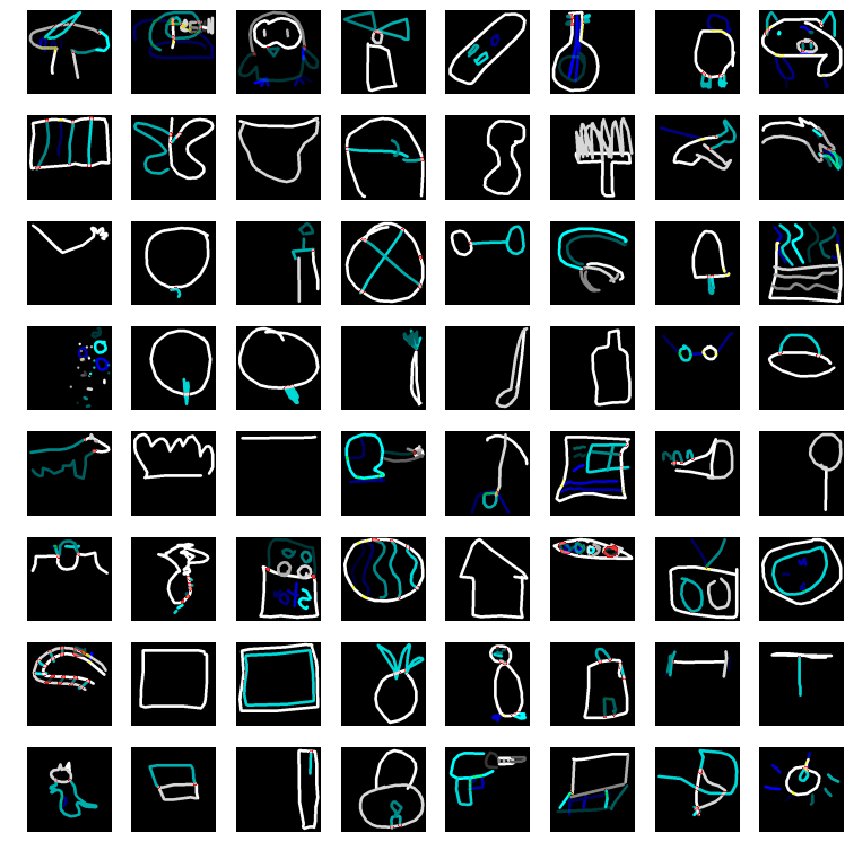

In [8]:
# Testing if image generator are working fine

x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n ** 2):
    ax = axs[i // n, i % n]
    (-x[i] + 1) / 2
    ax.imshow((-x[i, :, :, :] + 1) / 2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [9]:
model_type = 'Xception'
bst_model_path = 'dnn_'+model_type+'_fold'+str(fold)+'.h5'

callbacks = [
    ModelCheckpoint(monitor='val_categorical_accuracy', 
                    filepath=bst_model_path, 
                    save_best_only=True, 
                    verbose=1,
                    mode='max'),
    
    EarlyStopping(monitor='val_categorical_accuracy', 
                  mode = 'max',
                  patience=5, 
                  verbose=1),
    
    ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                      factor=0.5, 
                      patience=3,
                      min_delta=0.005, 
                      mode='max', 
                      cooldown=3, 
                      verbose=1)    
    ]
hists = []
hist = model.fit_generator(
    train_datagen, 
    steps_per_epoch=STEPS, 
    epochs=EPOCHS, 
    verbose=2,
    validation_data=valid_datagen, 
    validation_steps=STEPS / n_split,
    callbacks=callbacks
)
hists.append(hist)

print("EVAL:", eval(model.optimizer.lr))

Epoch 1/2
 9/10 [==========================>...] - ETA: 7s - loss: 7.8421 - categorical_crossentropy: 7.8421 - categorical_accuracy: 0.0047 - top_3_accuracy: 0.0195 
Epoch 00001: val_categorical_accuracy improved from -inf to 0.00263, saving model to dnn_Xception_fold9.h5
10/10 [==============================] - 82s 8s/step - loss: 7.7149 - categorical_crossentropy: 7.7149 - categorical_accuracy: 0.0045 - top_3_accuracy: 0.0186 - val_loss: 16.0757 - val_categorical_crossentropy: 16.0757 - val_categorical_accuracy: 0.0026 - val_top_3_accuracy: 1.0000
Epoch 2/2
 9/10 [==========================>...] - ETA: 1s - loss: 6.4713 - categorical_crossentropy: 6.4713 - categorical_accuracy: 0.0029 - top_3_accuracy: 0.0192
Epoch 00002: val_categorical_accuracy did not improve from 0.00263
10/10 [==============================] - 20s 2s/step - loss: 6.4571 - categorical_crossentropy: 6.4571 - categorical_accuracy: 0.0031 - top_3_accuracy: 0.0212 - val_loss: 16.1181 - val_categorical_crossentropy: 1

bst_val_loss 16.075681686401367
bst_val_categorical_accuracy 0.0026315790601074696


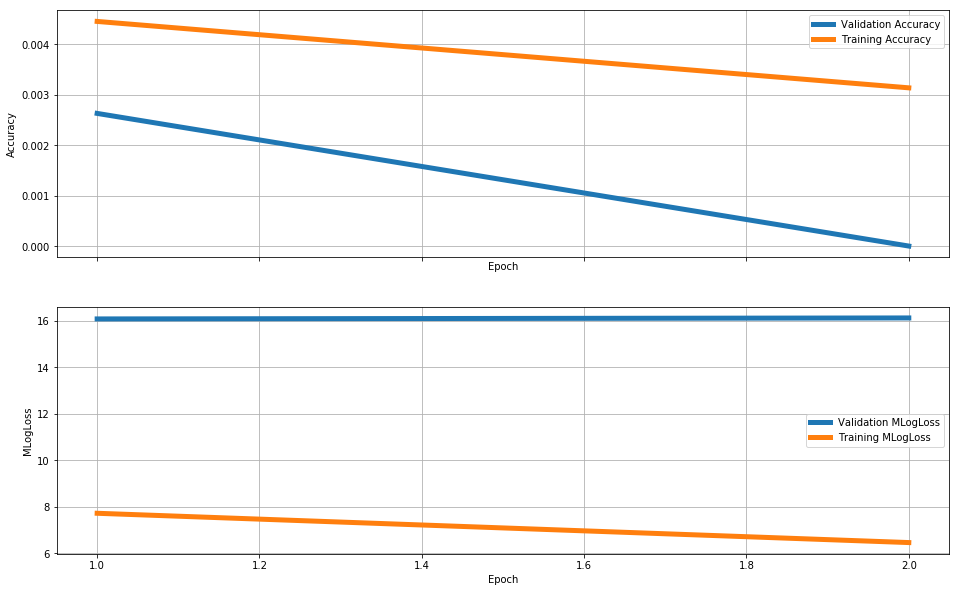

In [10]:
bst_val_score = min(hist.history['val_loss'])
print("bst_val_loss", bst_val_score)

bst_val_score = max(hist.history['val_categorical_accuracy'])
print("bst_val_categorical_accuracy", bst_val_score)

hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists])
hist_df.index = np.arange(1, len(hist_df) + 1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist'+model_type+'_fold'+str(fold)+'.png', dpi=300)
#plt.show();

In [11]:
model = load_model(bst_model_path, custom_objects={'top_3_accuracy': top_3_accuracy})

In [12]:
test = pd.read_csv(os.path.join(TEST_INPUT_DIR, 'test_simplified.csv'))

In [17]:
for n, batch in tqdm(enumerate(pd.read_csv(os.path.join(TEST_INPUT_DIR, 'test_simplified.csv'), chunksize=1024*5))):
    
    x_test = np.array([np.moveaxis(draw_temporal_strokes(ast.literal_eval(item), 
                                                     size=size, 
                                                     line_width=7, 
                                                     padding=10, 
                                                     fliplr=False, 
                                                     extended_channels=False), 0, -1) for item in batch.drawing])

    if n==0:
        test_predictions_a = model.predict(x_test, batch_size=512, verbose=2)
    else:
        test_predictions_a = np.vstack((test_predictions_a, model.predict(x_test, batch_size=512, verbose=1)))

    x_test = np.array([np.moveaxis(draw_temporal_strokes(ast.literal_eval(item), 
                                                         size=size, 
                                                         line_width=7, 
                                                         padding=10, 
                                                         fliplr=True, 
                                                         extended_channels=False), 0, -1) for item in batch.drawing])


    if n==0:
        test_predictions_b = model.predict(x_test, batch_size=512, verbose=2)
    else:
        test_predictions_b = np.vstack((test_predictions_b, model.predict(x_test, batch_size=512, verbose=1)))




0it [00:00, ?it/s]

1it [00:32, 32.80s/it]

5120/5120 [==============================] - 7s 1ms/step




2it [01:04, 32.61s/it]

5120/5120 [==============================] - 7s 1ms/step




3it [01:37, 32.47s/it]

5120/5120 [==============================] - 7s 1ms/step




4it [02:08, 32.29s/it]

5120/5120 [==============================] - 7s 1ms/step




5it [02:41, 32.22s/it]

5120/5120 [==============================] - 7s 1ms/step




6it [03:13, 32.17s/it]

5120/5120 [==============================] - 7s 1ms/step




7it [03:45, 32.13s/it]

5120/5120 [==============================] - 7s 1ms/step




8it [04:17, 32.09s/it]

5120/5120 [==============================] - 7s 1ms/step




9it [04:49, 32.07s/it]

5120/5120 [==============================] - 7s 1ms/step




10it [05:21, 32.01s/it]

5120/5120 [==============================] - 7s 1ms/step




11it [05:52, 31.99s/it]

5120/5120 [==============================] - 7s 1ms/step




12it [06:24, 31.98s/it]

5120/5120 [==============================] - 7s 1ms/step




13it [06:56, 31.99s/it]

5120/5120 [==============================] - 7s 1ms/step




14it [07:28, 31.98s/it]

5120/5120 [==============================] - 7s 1ms/step




15it [08:00, 32.01s/it]

5120/5120 [==============================] - 7s 1ms/step




16it [08:32, 31.99s/it]

5120/5120 [==============================] - 7s 1ms/step




17it [09:04, 32.01s/it]

5120/5120 [==============================] - 7s 1ms/step




18it [09:36, 31.88s/it]

5120/5120 [==============================] - 6s 1ms/step




19it [10:07, 31.73s/it]

5120/5120 [==============================] - 6s 1ms/step




20it [10:39, 31.61s/it]

5120/5120 [==============================] - 7s 1ms/step




21it [11:10, 31.58s/it]

4679/4679 [==============================] - 6s 1ms/step




22it [11:39, 30.87s/it]



In [25]:
test_predictions = 0.8 * test_predictions_a + 0.2 * test_predictions_b

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('gs_mn_submission_{}.csv'.format(1), index=False)
submission.head()
submission.shape

(112199, 2)

In [ ]:
print("SAVED:", 'gs_mn_submission_{}.csv'.format(1))